In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn

%matplotlib inline

# 1. Verify that PCA fails

In [180]:
w13_small_df = pd.read_table("w13-data-small.tbl.txt", delim_whitespace = True)
w13_small_df = np.log(w13_small_df + 1)
c_w13s = w13_small_df - w13_small_df.mean(axis=0)
#c_w13s.replace([np.inf, -np.inf], np.nan)
#c_w13s.dropna()
w13_small_df.head()

,nectarine,cauliflower,pineapple,tangerine,watermelon,papaya,endive,ginger,lettuce,broccoli,...,lime,guava,parsley,chickpea,horseradish,wasabi,artichoke,pumpkin,zucchini,type
0,4.521789,3.871201,3.891820,5.609472,4.442651,4.709530,6.075346,0.000000,4.234107,3.761200,...,1.098612,5.758902,5.273000,4.584967,2.397895,4.394449,0.000000,0.000000,3.761200,1.945910
1,5.463832,0.693147,5.736572,3.610918,4.595120,4.262680,1.098612,0.693147,5.480639,4.248495,...,1.386294,5.877736,4.356709,4.736198,5.411646,4.844187,0.693147,1.098612,4.691348,1.609438
2,0.000000,0.693147,3.784190,0.000000,4.653960,3.637586,1.098612,1.791759,5.049856,4.369448,...,0.693147,0.000000,3.713572,2.995732,5.446737,3.912023,1.098612,0.000000,4.882802,0.000000
3,1.098612,4.369448,2.995732,0.693147,5.446737,4.369448,2.772589,1.098612,4.753590,4.584967,...,0.000000,0.000000,5.117994,3.761200,3.555348,4.127134,0.000000,1.386294,2.484907,1.098612
4,1.098612,5.814131,5.463832,0.000000,3.091042,4.382027,5.017280,4.442651,4.653960,4.488636,...,6.274762,0.000000,4.700480,5.030438,4.442651,5.501258,4.644391,5.463832,3.091042,1.386294


In [181]:
#not using logspace to avoid the nan and inf issues
w13_large_df = pd.read_table("w13-data-large.tbl.txt", delim_whitespace = True)
w13_large_df = np.log(w13_large_df + 1)
c_w13l = w13_large_df - w13_large_df.mean(axis=0)

In [182]:
Us, Ss, Wts = np.linalg.svd(c_w13s)

In [183]:
Ul, Sl, Wtl = np.linalg.svd(c_w13l)

In [184]:
#calculate eigenvalues using the S matrix and the centered data matrix
eigenvalues_s = np.divide(np.power(Ss, 2), len(c_w13s)-1)

In [185]:
#calculate eigenvalues using the S matrix and the centered data matrix
eigenvalues_l = np.divide(np.power(Sl, 2), len(c_w13l)-1)

In [186]:
eigenvalues_s

array([2.63154667e+01, 2.24114599e+01, 1.96594952e+01, 1.40700266e+00,
       1.31718355e+00, 1.12607209e+00, 1.08075928e+00, 1.00621671e+00,
       9.38049490e-01, 7.87051565e-01, 7.23716668e-01, 6.30906344e-01,
       4.90696313e-01, 4.28798138e-01, 3.60424409e-01, 3.17655584e-01,
       2.67987260e-01, 2.03939499e-01, 1.86890161e-01, 1.20134928e-01,
       7.48793735e-02, 6.54153819e-02, 3.86510304e-02, 2.78754206e-02,
       1.43830170e-02])

In [187]:
#Transpose the rank by gene matrix to get the eigenvector matrix
Ws = Wts.T
#get principle components by multiplying the centered data matrix by the first (PC1) and second (PC2) eigenvectors
PC1s = c_w13s @ Ws[:,0]
PC2s = c_w13s @ Ws[:,1]

Text(0.5,1,'PC1s v. PC2s')

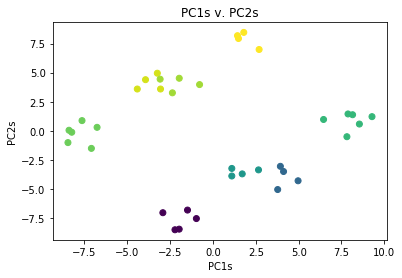

In [188]:
#Plot PC1 v. PC2 for low-dimensional visualization
plt.scatter(PC1s, PC2s, c=w13_small_df['type'])
plt.xlabel('PC1s')
plt.ylabel('PC2s')
plt.title('PC1s v. PC2s')

In [189]:
#Transpose the rank by gene matrix to get the eigenvector matrix
Wl = Wtl.T
#get principle components by multiplying the centered data matrix by the first (PC1) and second (PC2) eigenvectors
PC1l = c_w13l @ Wl[:,0]
PC2l = c_w13l @ Wl[:,1]

Text(0.5,1,'PC1l v. PC2l')

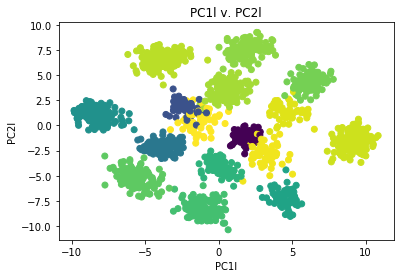

In [190]:
#Plot PC1 v. PC2 for low-dimensional visualization
plt.scatter(PC1l, PC2l, c=w13_large_df['type'])
plt.xlabel('PC1l')
plt.ylabel('PC2l')
plt.title('PC1l v. PC2l')

As you can see, I have been able to reproduce Moriarty's Brain Atlas results for part 1. 

## 2. Implement t-SNE for yourself

In [191]:
'''
Inputs:
- X : points in high dimensional space (n X m matrix, where n rows represent points, and m columns represent dimensions)

Intermediates:
- P : P_ij represents the probability of i -> j transition in high dimensional space
- Q : Q_ij represents the probability of i -> j transition in low dimensional space
- S : S_i represents sigma_i, the variance around point x_i in high dimensional space

Output:
- Y : points in low dimensional space (n X 2 matrix, rows represent cells, columns represent x- and y- axis)
'''

def distance(X):
    
    d = np.zeros((len(X), len(X)))
    
    for i in range(len(X)):
        for j in range(len(X)):
            d[i, j] = np.linalg.norm(X.iloc[i]-X.iloc[j])
    
    return d

def my_perplexity_diff(S, d):
    # calculate the perplexity for distance matrix row D[i] given sigma
    # return that minus the desired perplexity: we're looking for a zero difference
    # find your a,b bracketing interval
   
    pj_i = np.zeros(len(d))
    
    t = np.where(d == 0)
    
    for i in range(len(d)):
        if i != t:
            pj_i[i] = np.exp(-d[i]**2/(2*S**2))
    
    denom = pj_i.sum()
    
    pj_i = pj_i/denom
    
    H = 0
    
    for i in pj_i:
        if i != 0:
            H += - i*np.log2(i) 
    
    return 2**H - 5 #choosing target perplexity value from part 3 results

def get_sigmas(d):
       
    S = np.zeros(len(d)) 
    
    for i in range(len(d)):
        a = 1.0
        b = 1.0
        while my_perplexity_diff(a, d[i]) >= 0: a /= 2
        while my_perplexity_diff(b, d[i]) <= 0: b *= 2
    
        S[i] = scipy.optimize.bisect(my_perplexity_diff, a, b, args=(d[i].flatten()))
        
    return S

def get_pij(d, S):
    
    pj_i = np.zeros((len(d), len(d)))
    
    for i in range(len(d)):
        for j in range(len(d)):
            if i!=j:
                pj_i[i, j] = np.exp(-d[i, j]**2/(2*S[i]**2))
    
    np.fill_diagonal(pj_i, 0)
    denom = pj_i.sum(axis=1)
    pj_i = pj_i/denom
    
    pij = np.divide((pj_i + pj_i.T), 2*len(d))
    
    return pij

def get_P(X):
    
    d = distance(X)
    Sigmas = get_sigmas(d) 
    Pij = get_pij(d, Sigmas)
    
    return Pij
    

def get_cost_func_grad(Y, P):

    Y = np.reshape(Y, (len(P), 2))
    Q = np.zeros((len(P), len(P)))

    for i in range(len(P)):
        for j in range(len(P)):
            if i != j:
                Q[i, j] = 1/(1+ (np.linalg.norm(Y[i] - Y[j]))**2)
   
    np.fill_diagonal(Q, 0)
    denom = Q.sum().sum()
    Q = Q/denom
    
    KL = 0
    
    for i in range(len(P)):
        for j in range(len(P)):
            if P[i, j] != 0:
                KL += P[i, j]*np.log((P[i,j])/(Q[i,j]))
    
    grad = np.zeros((len(P), 2))
    
    for i in range(len(P)):
        for j in range(len(P)):
            if i !=j:
                grad[i] += (P[i, j] -  Q[i, j])*(Y[i]-Y[j])*((1)/(1 + np.linalg.norm(Y[i] - Y[j])**2))
        
        grad[i] = 4.0*grad[i]
        
    return KL, grad.flatten()
            
def do_tSNE(X):
    
    # Calculate P
    P = get_P(X)
    
    print(P.sum())
    
    #coordinates of 2D representation of cells
    Y = np.random.normal(0., 10000., (len(X), 2))
    
    # optimize
    s = scipy.optimize.minimize(get_cost_func_grad, Y.flatten(), args=(P), jac=True)
    
    Y = s.x.reshape(len(P), 2)
    
    return Y, s.fun

In [208]:
twoD_rep_coords, KL_dist = do_tSNE(w13_small_df)

0.9950156448054999


In [209]:
KL_dist

2.3155478287281763

In [210]:
twoD_rep_coords

array([[ 15633.26230275,   1411.33673799],
       [ -1166.13801384,   7296.84482441],
       [  2170.80394065,  12703.5386385 ],
       [-15174.65492865,   7182.40210471],
       [-13337.64982343,  15625.09423282],
       [  9181.30894348,  14200.65539387],
       [  -778.5666742 ,  -1875.90091135],
       [ 15961.38841557,  -2979.57094173],
       [  2968.38377797,  18757.14806232],
       [  3417.60417446, -16386.75943364],
       [  9656.90515999,   9294.43142943],
       [  4158.71084921,   3771.0183677 ],
       [  7775.88745099,   2216.74934023],
       [ 18752.89223038, -10597.971563  ],
       [  1324.5180572 ,  -5295.5335676 ],
       [ -5935.96895362,  -1784.37539569],
       [ -9965.830533  ,   1224.10891205],
       [ -3140.21599761,   2681.0269416 ],
       [  8628.28459655,  -6252.73865895],
       [  9632.81318212,  17928.7622158 ],
       [ -1550.22257454, -15941.26464906],
       [  -188.8189117 , -11719.42098276],
       [  6933.16666485, -11243.72210139],
       [ 20

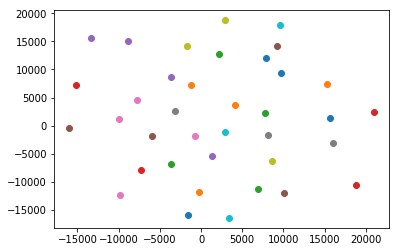

In [211]:
for i in range(len(w13_small_df)):
    plt.plot(twoD_rep_coords[i, 0],twoD_rep_coords[i, 1], marker="o")

## 3. Using the canned t-SNE from scikit 

In [196]:
#trying different perplexities as asked in the pset instructions
tsne_s2 = sklearn.manifold.TSNE(n_components=2, perplexity=2).fit_transform(c_w13s)
tsne_s5 = sklearn.manifold.TSNE(n_components=2, perplexity=5).fit_transform(c_w13s)
tsne_s30 = sklearn.manifold.TSNE(n_components=2, perplexity=30).fit_transform(c_w13s)
tsne_s100 = sklearn.manifold.TSNE(n_components=2, perplexity=100).fit_transform(c_w13s)

In [197]:
tsne_l2 = sklearn.manifold.TSNE(n_components=2, perplexity=2).fit_transform(c_w13l)
tsne_l5 = sklearn.manifold.TSNE(n_components=2, perplexity=5).fit_transform(c_w13l)
tsne_l30 = sklearn.manifold.TSNE(n_components=2, perplexity=30).fit_transform(c_w13l)
tsne_l100 = sklearn.manifold.TSNE(n_components=2, perplexity=100).fit_transform(c_w13l)

In [198]:
xs2 = tsne_s2[:,0]
ys2 = tsne_s2[:,1]

xs5 = tsne_s5[:,0]
ys5 = tsne_s5[:,1]

xs30 = tsne_s30[:,0]
ys30 = tsne_s30[:,1]

xs100 = tsne_s100[:,0]
ys100 = tsne_s100[:,1]

xl2 = tsne_l2[:,0]
yl2 = tsne_l2[:,1]

xl5 = tsne_l5[:,0]
yl5 = tsne_l5[:,1]

xl30 = tsne_l30[:,0]
yl30 = tsne_l30[:,1]

xl100 = tsne_l100[:,0]
yl100 = tsne_l100[:,1]

Text(0,0.5,'tsne-2')

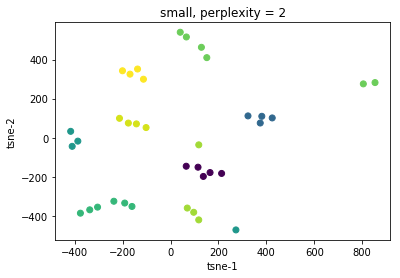

In [199]:
plt.scatter(xs2,ys2,  c=w13_small_df['type'])
plt.title('small, perplexity = 2')
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')

Text(0,0.5,'tsne-2')

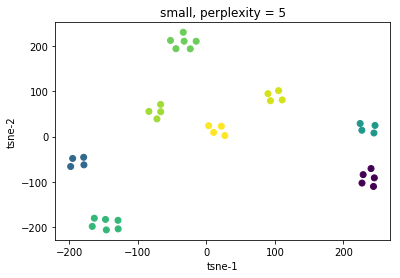

In [200]:
plt.scatter(xs5,ys5, c=w13_small_df['type'])
plt.title('small, perplexity = 5')
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')

Text(0,0.5,'tsne-2')

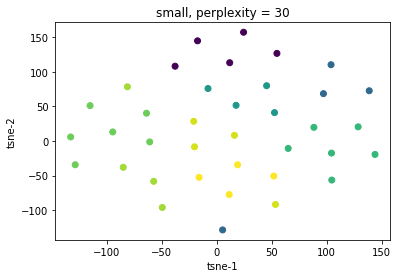

In [201]:
plt.scatter(xs30,ys30, c=w13_small_df['type'])
plt.title('small, perplexity = 30')
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')

Text(0,0.5,'tsne-2')

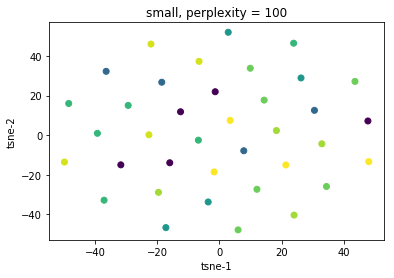

In [202]:
plt.scatter(xs100,ys100, c=w13_small_df['type'])
plt.title('small, perplexity = 100')
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')

In [203]:
#repeat for large dataset

Text(0,0.5,'tsne-2')

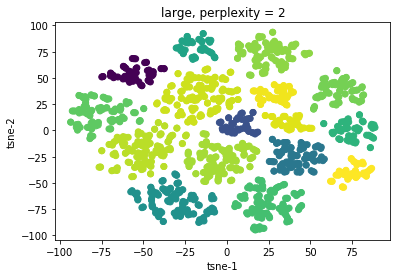

In [204]:
plt.scatter(xl2,yl2,  c=w13_large_df['type'])
plt.title('large, perplexity = 2')
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')

Text(0,0.5,'tsne-2')

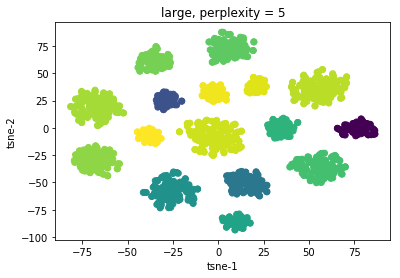

In [205]:
plt.scatter(xl5,yl5, c=w13_large_df['type'])
plt.title('large, perplexity = 5')
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')

Text(0,0.5,'tsne-2')

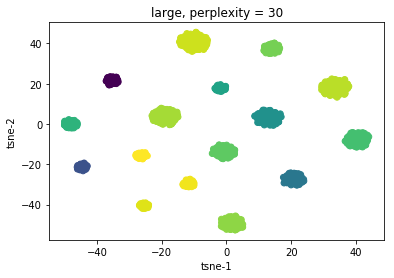

In [206]:
plt.scatter(xl30,yl30, c=w13_large_df['type'])
plt.title('large, perplexity = 30')
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')

Text(0,0.5,'tsne-2')

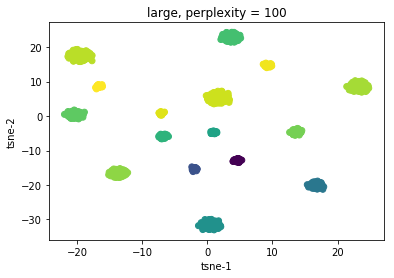

In [207]:
plt.scatter(xl100,yl100, c=w13_large_df['type'])
plt.title('large, perplexity = 100')
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')

For the dataset, it seems like a perplexity of 5 gives the best clustering, without overiftting to the data, and without leaving the data clusters too close together space. So, for part 2 I will use a perplexity of 5. 